# Fetch Codebase

In [1]:
#@title
import os
#os.chdir('/content')
#CODE_DIR = 'sefa'
#!git clone https://github.com/genforce/sefa.git $CODE_DIR
#os.chdir(f'./{CODE_DIR}')
os.chdir("./sefa-cryowgan")
os.getcwd()

'/home/o.liagkas/projects/Factorized_CryoEM_wgan/sefa-cryowgan'

In [2]:
os.listdir()

['README.md',
 'models',
 'swagan_utils.py',
 'sefa.py',
 'LICENSE',
 'utils.py',
 '__pycache__',
 '.ipynb_checkpoints',
 'checkpoints',
 'latent_codes',
 'interface.py',
 'SessionState.py',
 'swagan_multilayer_utils.py']

In [3]:
### IMPORT DEPENDENCIES:
os.chdir("./models")
import math
import random
import functools
import operator

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Function

from op import FusedLeakyReLU, fused_leaky_relu, upfirdn2d, conv2d_gradfix
from stylegan import (
    ModulatedConv2d,
    StyledConv,
    ConstantInput,
    PixelNorm,
    Upsample,
    Downsample,
    Blur,
    EqualLinear,
    ConvLayer,
)

In [3]:
#DEPENDENCIES FOR 1 OUT CHANNEL
### IMPORT DEPENDENCIES:
os.chdir("./models")
import math
import random
import functools
import operator

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Function

from op import FusedLeakyReLU, fused_leaky_relu, upfirdn2d, conv2d_gradfix
from stylegan_1OutCh import (
    ModulatedConv2d,
    StyledConv,
    ConstantInput,
    PixelNorm,
    Upsample,
    Downsample,
    Blur,
    EqualLinear,
    ConvLayer,
)

# Define Utility Functions

In [3]:
from models import MODEL_ZOO
print(MODEL_ZOO.keys())

dict_keys(['cryoEM_wgan', 'pggan_celebahq1024', 'pggan_bedroom256', 'pggan_livingroom256', 'pggan_diningroom256', 'pggan_kitchen256', 'pggan_church256', 'pggan_tower256', 'pggan_bridge256', 'pggan_restaurant256', 'pggan_classroom256', 'pggan_conferenceroom256', 'pggan_person256', 'pggan_cat256', 'pggan_dog256', 'pggan_bird256', 'pggan_horse256', 'pggan_sheep256', 'pggan_cow256', 'pggan_car256', 'pggan_bicycle256', 'pggan_motorbike256', 'pggan_bus256', 'pggan_train256', 'pggan_boat256', 'pggan_airplane256', 'pggan_bottle256', 'pggan_chair256', 'pggan_pottedplant256', 'pggan_tvmonitor256', 'pggan_diningtable256', 'pggan_sofa256', 'stylegan_ffhq1024', 'stylegan_celebahq1024', 'stylegan_bedroom256', 'stylegan_cat256', 'stylegan_car512', 'stylegan_celeba_partial256', 'stylegan_ffhq256', 'stylegan_ffhq512', 'stylegan_livingroom256', 'stylegan_diningroom256', 'stylegan_kitchen256', 'stylegan_apartment256', 'stylegan_church256', 'stylegan_tower256', 'stylegan_bridge256', 'stylegan_restaurant25

In [4]:
os.chdir('../')

#@title
import os.path
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image

import torch

from models import parse_gan_type
from swagan_utils import to_tensor
from swagan_utils import postprocess
from swagan_utils import load_generator
from swagan_utils import factorize_weight


def sample(generator, gan_type, num=1, seed=11):
    """Samples latent codes."""
    #torch.manual_seed(seed)                                                                    TURNED OFF SEEDING!!!!
    #codes = torch.randn(num, generator.z_space_dim).cuda()     CHANGED FOR OUR GAN
    codes = torch.randn((num, 100, 1, 1)).cuda()
    codes = pixel_norm_layer(generator.net[0](codes))
    '''
    if gan_type == 'pggan':
        codes = generator.layer0.pixel_norm(codes)
    elif gan_type == 'stylegan':
        codes = generator.mapping(codes)['w']
        codes = generator.truncation(codes, trunc_psi=0.7, trunc_layers=8)
    elif gan_type == 'stylegan2':
        codes = generator.mapping(codes)['w']
        codes = generator.truncation(codes, trunc_psi=0.5, trunc_layers=18)
    '''
    codes = codes.detach().cpu().numpy()
    return codes

def pixel_norm_layer(x):
    """Implements pixel-wise feature vector normalization layer."""
    norm = torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8)
    return x / norm


def synthesize(generator, gan_type, codes):
    """Synthesizes images with the give codes."""
    '''
  if gan_type == 'pggan':
    images = generator(to_tensor(codes))['image']
  elif gan_type == 'cryowgan':   #################################FOR US!!
     return generator(to_tensor(codes))
  elif gan_type in ['stylegan', 'stylegan2']:
    images = generator.synthesis(to_tensor(codes))['image']
      '''
    #images = generator(to_tensor(codes)) ##########
    images, _ = g_ema( codes
                , truncation=1, truncation_latent=None
            )   # CODES NEED TO BE IN FORMAT: [torch.randn(1, 512, device=device)]
    images = postprocess(images)
    return images


from PIL import Image


def imshow(images, col, viz_size=128):
    """Shows images in one figure."""
    num, height, width, channels = images.shape
    assert num % col == 0
    row = num // col

    # Create an empty array to hold the fused image
    # Initialize the fused_image with 3 channels (for RGB)
    fused_image = np.zeros((viz_size * row, viz_size * col, 3), dtype=np.uint8)

    for idx, image in enumerate(images):
        i, j = divmod(idx, col)
        y = i * viz_size
        x = j * viz_size
        
        # Resize image if it's not the desired size
        if height != viz_size or width != viz_size:
            image = cv2.resize(image, (viz_size, viz_size))
        
        # Handle grayscale images by converting them to 3 channels
        if channels == 1:
            image = np.repeat(image, 3, axis=-1)  # Repeat the grayscale image across 3 channels
        
        # Place the image into the correct position in the fused image
        fused_image[y:y + viz_size, x:x + viz_size] = image

    # Convert to uint8 if not already in that format
    fused_image = np.asarray(fused_image, dtype=np.uint8)

    # Directly display the image in the notebook
    pil_image = Image.fromarray(fused_image)
    pil_image.show()

    return pil_image


# Select a Model

In [5]:
os.chdir('./models')

#from swagan import Generator
#FOR 1 OUT CHANNEL:
#from swagan_1OutCh import Generator
from stylegan_1OutCh import Generator

gan_type = 'cryowgan' # for now to check usability

size = 128  
latent_dim = 512
n_mlp = 8
channel_multiplier = 2
#PATH = '../../../cryo_swagan/checkpoint/400000.pt'
#FOR 1 OUT CHANNEL:
#PATH = '../../../cryo_swagan/checkpoint_1OutCh/390000.pt'
PATH = '../../../cryo_swagan/checkpoint_1OutCh/stylegan_390000.pt'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
g_ema = Generator(size, latent_dim, n_mlp, channel_multiplier=channel_multiplier).to(device)

checkpoint = torch.load(PATH)
print(checkpoint.keys())
g_ema.load_state_dict(checkpoint["g_ema"])

g_ema.eval()


dict_keys(['g', 'd', 'g_ema', 'g_optim', 'd_optim', 'args', 'ada_aug_p'])


Generator(
  (style): Sequential(
    (0): PixelNorm()
    (1): EqualLinear(512, 512)
    (2): EqualLinear(512, 512)
    (3): EqualLinear(512, 512)
    (4): EqualLinear(512, 512)
    (5): EqualLinear(512, 512)
    (6): EqualLinear(512, 512)
    (7): EqualLinear(512, 512)
    (8): EqualLinear(512, 512)
  )
  (input): ConstantInput()
  (conv1): StyledConv(
    (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
    (noise): NoiseInjection()
    (activate): FusedLeakyReLU()
  )
  (to_rgb1): ToGray(
    (conv): ModulatedConv2d(512, 1, 1, upsample=False, downsample=False)
  )
  (convs): ModuleList(
    (0): StyledConv(
      (conv): ModulatedConv2d(512, 512, 3, upsample=True, downsample=False)
      (noise): NoiseInjection()
      (activate): FusedLeakyReLU()
    )
    (1): StyledConv(
      (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
      (noise): NoiseInjection()
      (activate): FusedLeakyReLU()
    )
    (2): StyledConv(
      (conv): Modu

In [5]:
#@title { display-mode: "form", run: "auto" }
model_name = "cryoEM_wgan" #@param ['stylegan_animeface512', 'stylegan_car512', 'stylegan_cat256', 'pggan_celebahq1024', 'stylegan_bedroom256']

generator = load_generator(model_name, '../sefa-cryowgan/checkpoints/run26_10k_checkpoint_netG.tar')
gan_type = parse_gan_type(generator)

Building generator for model `cryoEM_wgan` ...
Finish building generator.
Loading checkpoint from `../sefa-cryowgan/checkpoints/run26_10k_checkpoint_netG.tar` ...


RuntimeError: Error(s) in loading state_dict for Cryo_EM_Generator:
	Missing key(s) in state_dict: "net.16.norm.weight", "net.16.norm.bias", "net.18.weight". 
	size mismatch for net.15.weight: copying a param with shape torch.Size([32, 1, 4, 4]) from checkpoint, the shape in current model is torch.Size([32, 16, 4, 4]).

# Sample Latent Codes

/home/o.liagkas/projects/Factorized_CryoEM_wgan/sefa-cryowgan/models/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.0.0+cu118. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


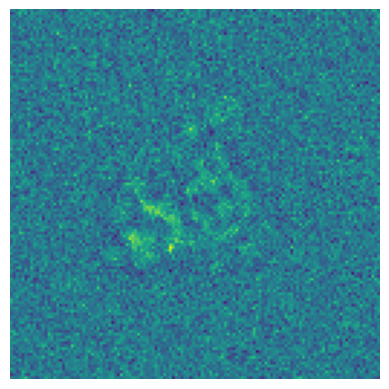

In [6]:
import matplotlib.pyplot as plt

def show_image(tensor):
    # Move to CPU and remove gradients
    img = sample[0].detach().cpu()

    # Denormalize: Convert from range (-1, 1) to (0, 1)
    img = (img - img.min()) / (img.max() - img.min())

    # Convert to NumPy format (C, H, W) -> (H, W, C)
    img = img.permute(1, 2, 0).numpy()

    # Display the image
    plt.imshow(img)
    plt.axis("off")  # Hide axes
    plt.show()

sample, _ = g_ema(
                [torch.randn(1, 512, device=device)], truncation=1, truncation_latent=None
            )
show_image(sample[0].detach())

torch.Size([12, 512])


/home/o.liagkas/projects/Factorized_CryoEM_wgan/sefa-cryowgan/models/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.0.0+cu118. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


(12, 128, 128, 1)


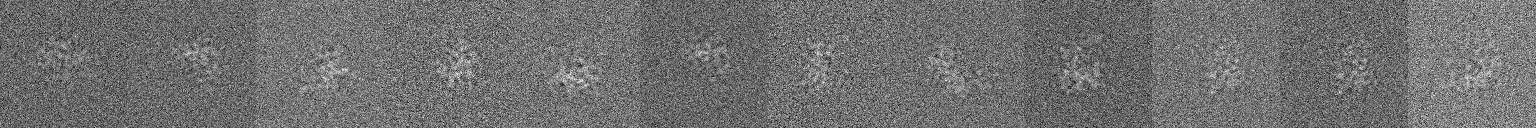

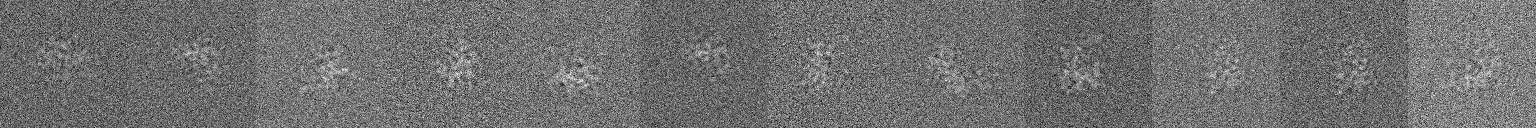

In [6]:
#@title { display-mode: "form", run: "auto" }

num_samples = 12 #@param {type:"slider", min:1, max:8, step:1}
noise_seed = 0 #@param {type:"slider", min:0, max:1000, step:1}

# OLD codes = torch.randn((num_samples,512,1,1)).detach().numpy()

codes = [torch.randn(num_samples, 512, device=device)]
print(codes[0].shape)

sample, _ = g_ema(
                [torch.randn(1, 512, device=device)], truncation=1, truncation_latent=None
            )

images2 = synthesize(g_ema, gan_type, codes)#codes) #torch.randn((num_samples, 100, 1, 1)).cuda()
print(images2.shape)
imshow(images2, col=num_samples)

In [7]:
def imprint(images, path ,col=1, viz_size=128):
    """Shows images in one figure."""
    #num, 
    height, width, channels = images.shape
    if channels == 1:    # added this so it identifies when there is an image of 1 channel
        images = images.squeeze(2)
    #assert num % col == 0
    #row = num // col 
    row = 1
    pil_image = Image.fromarray(images).convert('L')   # CHANGED TO CONVERT IT INTO GRAYSCALE IMAGE AT THE MOMENT OF SAVING!
    pil_image.save(path)
'''
    # Create an empty array to hold the fused image
    # Initialize the fused_image with 3 channels (for RGB)
    fused_image = np.zeros((viz_size * row, viz_size * col, 3), dtype=np.uint8)

    for idx, image in enumerate(images):
        i, j = divmod(idx, col)
        y = i * viz_size
        x = j * viz_size
        
        # Resize image if it's not the desired size
        if height != viz_size or width != viz_size:
            image = cv2.resize(image, (viz_size, viz_size))
        
        # Handle grayscale images by converting them to 3 channels
        if channels == 1:
            image = np.repeat(image, 3, axis=-1)  # Repeat the grayscale image across 3 channels
        
        # Place the image into the correct position in the fused image
        fused_image[y:y + viz_size, x:x + viz_size] = image

    # Convert to uint8 if not already in that format
    fused_image = np.asarray(fused_image, dtype=np.uint8)
    # Directly display the image in the notebook
    pil_image = Image.fromarray(images).convert('L')   # CHANGED TO CONVERT IT INTO GRAYSCALE IMAGE AT THE MOMENT OF SAVING!
    pil_image.save(path)
'''


"\n    # Create an empty array to hold the fused image\n    # Initialize the fused_image with 3 channels (for RGB)\n    fused_image = np.zeros((viz_size * row, viz_size * col, 3), dtype=np.uint8)\n\n    for idx, image in enumerate(images):\n        i, j = divmod(idx, col)\n        y = i * viz_size\n        x = j * viz_size\n        \n        # Resize image if it's not the desired size\n        if height != viz_size or width != viz_size:\n            image = cv2.resize(image, (viz_size, viz_size))\n        \n        # Handle grayscale images by converting them to 3 channels\n        if channels == 1:\n            image = np.repeat(image, 3, axis=-1)  # Repeat the grayscale image across 3 channels\n        \n        # Place the image into the correct position in the fused image\n        fused_image[y:y + viz_size, x:x + viz_size] = image\n\n    # Convert to uint8 if not already in that format\n    fused_image = np.asarray(fused_image, dtype=np.uint8)\n    # Directly display the image in 

In [19]:
os.getcwd()

'/home/o.liagkas/projects/Generated100K_SWAGAN_128_1OutCh'

In [8]:
### PARTICLE GENERATION ###
os.chdir("../../../Generated100K_STYLEGAN_128_1OutCh/")        #CHANGE LATER!
num_samples = 1

counter = 0

for j in range(1563):
    #mrc = str(j)
    
    if(j<10):
        jp = '00'+str(j) 

    elif(j<100):
        jp = '0'+str(j)

    else: #redundant ik
        jp = str(j)
        
    for i in range (64):
        i+=1

        counter += 1
        
        if counter > 100000:
            break

        particle = str(str(i).zfill(7))
        
        #if(int(mrc)>0):
        mrc=str(j).zfill(7)
        #else:
         #   mrc=str(j).zfill(6)

        particle_name = 'generated_particle_'+mrc+'_'+particle+".png"
        #generation_codes = torch.randn((num_samples,100,1,1)).detach().numpy()
        codes = [torch.randn(num_samples, 512, device=device)]
        
        generated_image = synthesize(g_ema, gan_type, codes)
        #print(generated_image.shape)
        imprint(generated_image[0], path=particle_name, col=1, viz_size=128)


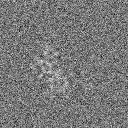

In [9]:
saved_image = Image.open("generated_particle_0000022_0000012.png")
saved_image.show()

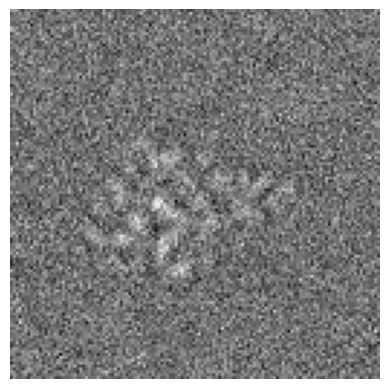

In [8]:
generated_image = synthesize(g_ema, gan_type, codes)
genimarray = np.array(generated_image[0])

plt.imshow(genimarray, cmap="gray")  # Remove cmap="gray" for color images
plt.axis("off")  
plt.show()

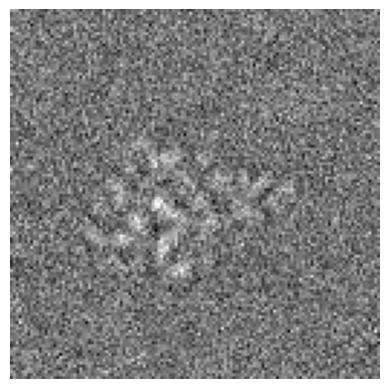

In [9]:
pil_image = Image.fromarray(genimarray).convert('L')
plt.imshow(pil_image, cmap="gray")  # Remove cmap="gray" for color images
plt.axis("off")  
plt.show()

In [9]:
os.chdir("../../../Generated100K_SWAGAN_128/")
os.getcwd()

'/home/o.liagkas/projects/Generated100K_SWAGAN_128'

In [18]:
names = sorted(os.listdir())
names[-1]

'generated_particle_0001562_0000032.png'

In [19]:
len(names)

100000

L


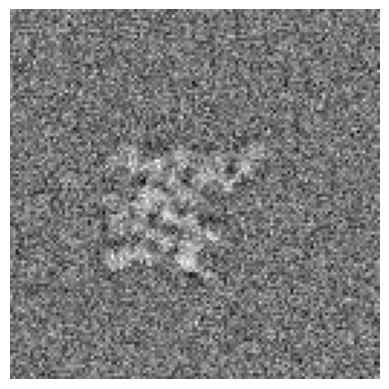

(128, 128)

In [33]:
image = Image.open("generated_particle_0001562_0000032.png")
print(image.mode)

imarray = np.array(image)

plt.imshow(imarray, cmap="gray")  # Remove cmap="gray" for color images
plt.axis("off")  
plt.show()

imarray.shape

# Factorize & Edit

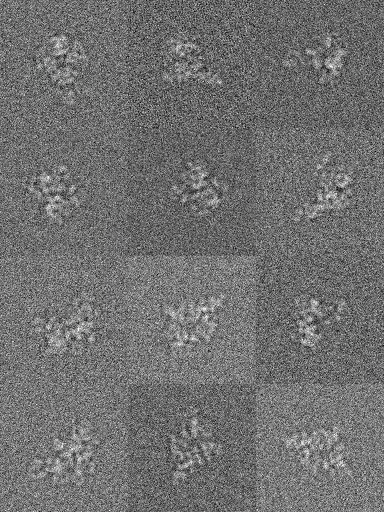

<PIL.Image.Image image mode=RGB size=384x512 at 0x7FA9B071D880>


In [8]:
#@title { display-mode: "form", run: "auto" }

layer_idx = "0" #@param ['all', '0-1', '2-5', '6-13']
semantic_1 = -1 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_2 = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_3 = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_4 = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_5 = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}

# Fast implementation to factorize the weight by SeFa.
layers, boundaries, _ = factorize_weight(g_ema, layer_idx)

new_codes = codes[0].detach().cpu()#.copy()
for sem_idx in range(5):
  boundary = boundaries[sem_idx:sem_idx + 1]
  step = eval(f'semantic_{sem_idx + 1}')
  if gan_type == 'cryowgan':
    new_codes += boundary * step
    #new_codes += (boundary.reshape(1, 100, 1, 1) * step)  #CHANGED TO INCLUDE CRYOWGAN
    final_codes = [new_codes]
    
  elif gan_type =='pggan':            
    new_codes += boundary * step
    
  elif gan_type in ['stylegan', 'stylegan2']:
    new_codes[:, layers, :] += boundary * step
# ADDED THIS!!!!!!!!
device = next(g_ema.parameters()).device  # Get the device of g_ema (which is cuda:0)
final_codes = [code.to(device) for code in final_codes]  # Move all codes to the same device

new_images = synthesize(g_ema, gan_type, final_codes)
print(imshow(new_images, col=3))

In [17]:
print(f"codes device: {final_codes[0].device}")
print(f"g_ema device: {next(g_ema.parameters()).device}")  # Check the device of a model parameter


codes device: cuda:0
g_ema device: cuda:0


In [16]:
# Ensure final_codes are on the same device as g_ema (which is on cuda:0)
device = next(g_ema.parameters()).device  # Get the device of g_ema (which is cuda:0)
final_codes = [code.to(device) for code in final_codes]  # Move all codes to the same device


In [13]:
tweight = g_ema.conv1.conv.weight
tweight[0].shape
tweight[0].flip(2, 3).permute(1, 0, 2, 3).flatten(1)

tensor([[-0.7603, -4.1994, -0.9757,  ...,  0.9760, -0.8636, -2.9555],
        [ 1.6067, -0.1025,  1.0561,  ..., -1.1575,  3.0760, -2.4857],
        [ 0.1662,  1.9335,  1.0949,  ..., -0.6551,  0.8596,  2.3651],
        ...,
        [-1.3344, -2.2886, -4.1238,  ..., -0.9946,  1.4768,  0.2917],
        [-0.7812,  3.0161, -0.7529,  ...,  0.4817, -0.1264, -0.4806],
        [ 0.1625,  2.1395,  0.5702,  ..., -2.4471, -0.6015,  1.2111]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>)

In [37]:
os.listdir('../')

['README.md',
 'models',
 'sefa.py',
 'LICENSE',
 'utils.py',
 '__pycache__',
 '.ipynb_checkpoints',
 'checkpoints',
 'latent_codes',
 'interface.py',
 'SessionState.py']

In [33]:
from cryowgan_generator import Cryo_EM_Generator
test_gen = Cryo_EM_Generator()


In [11]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output

# Define your layer and semantic controls as interactive widgets
layer_idx = widgets.Dropdown(
    options=['all', '0-1', '2-5', '6-13'],
    value='0-1',
    description='Layer Index:',
)

semantic_1 = widgets.FloatSlider(
    value=0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='Semantic 1:',
    continuous_update=True,
)

semantic_2 = widgets.FloatSlider(
    value=0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='Semantic 2:',
    continuous_update=True,
)

semantic_3 = widgets.FloatSlider(
    value=0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='Semantic 3:',
    continuous_update=True,
)

semantic_4 = widgets.FloatSlider(
    value=0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='Semantic 4:',
    continuous_update=True,
)

semantic_5 = widgets.FloatSlider(
    value=0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='Semantic 5:',
    continuous_update=True,
)

# Define a function that will update the visuals in real-time
def update_visual(layer_idx, semantic_1, semantic_2, semantic_3, semantic_4, semantic_5):
    clear_output(wait=True)  # Clear previous output to update in real time

    '''
    # Display the selected values
    print(f'Layer Index: {layer_idx}')
    print(f'Semantic 1: {semantic_1}')
    print(f'Semantic 2: {semantic_2}')
    print(f'Semantic 3: {semantic_3}')
    print(f'Semantic 4: {semantic_4}')
    print(f'Semantic 5: {semantic_5}')
    '''
    # Fast implementation to factorize the weight by SeFa.
    layers, boundaries, _ = factorize_weight(g_ema, layer_idx)

    new_codes = codes[0].detach().cpu()
    for sem_idx, step in enumerate([semantic_1, semantic_2, semantic_3, semantic_4, semantic_5]):
        boundary = boundaries[sem_idx:sem_idx + 1]
        if gan_type == 'pggan':
            new_codes += boundary * step
        elif gan_type == 'cryowgan':
            new_codes += boundary * step
            #new_codes += (boundary.reshape(1, 100, 1, 1) * step)  #CHANGED TO INCLUDE CRYOWGAN
            final_codes = [new_codes]
        elif gan_type in ['stylegan', 'stylegan2']:
            new_codes[:, layers, :] += boundary * step
    
    device = next(g_ema.parameters()).device  # Get the device of g_ema (which is cuda:0)
    final_codes = [code.to(device) for code in final_codes]  # Move all codes to the same device
    new_images = synthesize(g_ema, gan_type, final_codes)
    imshow(new_images, col=3)

# Use `interact` to create the interactive UI and trigger `update_visual`
interact(update_visual, 
         layer_idx=layer_idx, 
         semantic_1=semantic_1, 
         semantic_2=semantic_2, 
         semantic_3=semantic_3, 
         semantic_4=semantic_4, 
         semantic_5=semantic_5)

''' OLD
    new_codes = codes.copy()
    for sem_idx, step in enumerate([semantic_1, semantic_2, semantic_3, semantic_4, semantic_5]):
        boundary = boundaries[sem_idx:sem_idx + 1]
        if gan_type == 'pggan':
            new_codes += boundary * step
        elif gan_type == 'cryowgan':
            new_codes += (boundary.reshape(1, 100, 1, 1) * step)  #CHANGED TO INCLUDE CRYOWGAN
        elif gan_type in ['stylegan', 'stylegan2']:
            new_codes[:, layers, :] += boundary * step
    new_images = synthesize(g_ema, gan_type, new_codes)
    imshow(new_images, col=3)
'''

interactive(children=(Dropdown(description='Layer Index:', index=1, options=('all', '0-1', '2-5', '6-13'), val…

" OLD\n    new_codes = codes.copy()\n    for sem_idx, step in enumerate([semantic_1, semantic_2, semantic_3, semantic_4, semantic_5]):\n        boundary = boundaries[sem_idx:sem_idx + 1]\n        if gan_type == 'pggan':\n            new_codes += boundary * step\n        elif gan_type == 'cryowgan':\n            new_codes += (boundary.reshape(1, 100, 1, 1) * step)  #CHANGED TO INCLUDE CRYOWGAN\n        elif gan_type in ['stylegan', 'stylegan2']:\n            new_codes[:, layers, :] += boundary * step\n    new_images = synthesize(g_ema, gan_type, new_codes)\n    imshow(new_images, col=3)\n"

In [12]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output

# Define your layer and semantic controls as interactive widgets
layer_idx = widgets.Dropdown(
    options=['all', '0-1', '2-5', '6-13'],
    value='0-1',
    description='Layer Index:',
)

# Replace sliders with FloatText boxes for numeric input
semantic_1 = widgets.FloatText(
    value=0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='Semantic 1:',
    continuous_update=True,
)

semantic_2 = widgets.FloatText(
    value=0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='Semantic 2:',
    continuous_update=True,
)

semantic_3 = widgets.FloatText(
    value=0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='Semantic 3:',
    continuous_update=True,
)

semantic_4 = widgets.FloatText(
    value=0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='Semantic 4:',
    continuous_update=True,
)

semantic_5 = widgets.FloatText(
    value=0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='Semantic 5:',
    continuous_update=True,
)

# Define a function that will update the visuals in real-time
def update_visual(layer_idx, semantic_1, semantic_2, semantic_3, semantic_4, semantic_5):
    clear_output(wait=True)  # Clear previous output to update in real time

    # Fast implementation to factorize the weight by SeFa.
    layers, boundaries, _ = factorize_weight(g_ema, layer_idx)

    new_codes = codes[0].detach().cpu()
    for sem_idx, step in enumerate([semantic_1, semantic_2, semantic_3, semantic_4, semantic_5]):
        boundary = boundaries[sem_idx:sem_idx + 1]
        if gan_type == 'pggan':
            new_codes += boundary * step
        elif gan_type == 'cryowgan':
            new_codes += boundary * step
            #new_codes += (boundary.reshape(1, 100, 1, 1) * step)  #CHANGED TO INCLUDE CRYOWGAN
            final_codes = [new_codes]
        elif gan_type in ['stylegan', 'stylegan2']:
            new_codes[:, layers, :] += boundary * step
    
    device = next(g_ema.parameters()).device  # Get the device of g_ema (which is cuda:0)
    final_codes = [code.to(device) for code in final_codes]  # Move all codes to the same device
    new_images = synthesize(g_ema, gan_type, final_codes)
    imshow(new_images, col=3)

# Use `interact` to create the interactive UI and trigger `update_visual`
interact(update_visual, 
         layer_idx=layer_idx, 
         semantic_1=semantic_1, 
         semantic_2=semantic_2, 
         semantic_3=semantic_3, 
         semantic_4=semantic_4, 
         semantic_5=semantic_5)


interactive(children=(Dropdown(description='Layer Index:', index=1, options=('all', '0-1', '2-5', '6-13'), val…

<function __main__.update_visual(layer_idx, semantic_1, semantic_2, semantic_3, semantic_4, semantic_5)>

In [ ]:
##############################################################################################################################

In [ ]:
##############################################################################################################################

In [ ]:
####################################FOR MULTIPLE LAYERS#######################################################################

In [ ]:
##############################################################################################################################

In [ ]:
##############################################################################################################################

In [8]:
os.chdir('../')
os.listdir()

['README.md',
 'models',
 'swagan_utils.py',
 'sefa.py',
 'LICENSE',
 'utils.py',
 '__pycache__',
 '.ipynb_checkpoints',
 'checkpoints',
 'latent_codes',
 'interface.py',
 'SessionState.py',
 'swagan_multilayer_utils.py']

In [9]:
from swagan_multilayer_utils import factorize_weight_multilayer

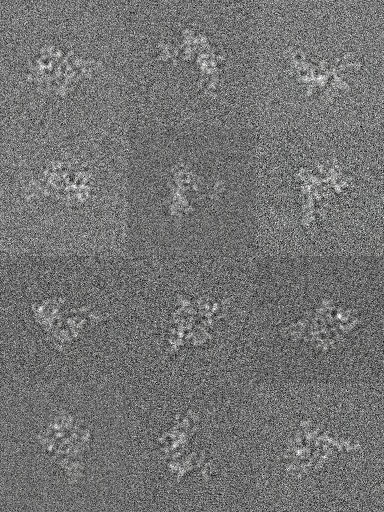

<PIL.Image.Image image mode=RGB size=384x512 at 0x7FD773C55490>


In [12]:
#@title { display-mode: "form", run: "auto" }

layer_idx = 'all' #@param ['all', '0-1', '2-5', '6-13']
semantic_1 = -3 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_2 = -3 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_3 = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_4 = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_5 = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}

# Fast implementation to factorize the weight by SeFa.
layers, boundaries, _ = factorize_weight_multilayer(g_ema, layer_idx)

new_codes = codes[0].detach().cpu()#.copy()
for sem_idx in range(5):
  boundary = boundaries[sem_idx:sem_idx + 1]
  step = eval(f'semantic_{sem_idx + 1}')
  if gan_type == 'cryowgan':
    new_codes += boundary * step
    #new_codes += (boundary.reshape(1, 100, 1, 1) * step)  #CHANGED TO INCLUDE CRYOWGAN
    final_codes = [new_codes]
    
  elif gan_type =='pggan':            
    new_codes += boundary * step
    
  elif gan_type in ['stylegan', 'stylegan2']:
    new_codes[:, layers, :] += boundary * step
# ADDED THIS!!!!!!!!
device = next(g_ema.parameters()).device  # Get the device of g_ema (which is cuda:0)
final_codes = [code.to(device) for code in final_codes]  # Move all codes to the same device

new_images = synthesize(g_ema, gan_type, final_codes)
print(imshow(new_images, col=3))

In [10]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output

# Define your layer and semantic controls as interactive widgets
layer_idx = widgets.Dropdown(
    options=['all', '0-1', '2-5', '6-13'],
    value='0-1',
    description='Layer Index:',
)

# Replace sliders with FloatText boxes for numeric input
semantic_1 = widgets.FloatText(
    value=0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='Semantic 1:',
    continuous_update=True,
)

semantic_2 = widgets.FloatText(
    value=0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='Semantic 2:',
    continuous_update=True,
)

semantic_3 = widgets.FloatText(
    value=0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='Semantic 3:',
    continuous_update=True,
)

semantic_4 = widgets.FloatText(
    value=0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='Semantic 4:',
    continuous_update=True,
)

semantic_5 = widgets.FloatText(
    value=0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='Semantic 5:',
    continuous_update=True,
)

# Define a function that will update the visuals in real-time
def update_visual(layer_idx, semantic_1, semantic_2, semantic_3, semantic_4, semantic_5):
    clear_output(wait=True)  # Clear previous output to update in real time

    # Fast implementation to factorize the weight by SeFa.
    layers, boundaries, _ = factorize_weight_multilayer(g_ema, layer_idx)

    new_codes = codes[0].detach().cpu()
    for sem_idx, step in enumerate([semantic_1, semantic_2, semantic_3, semantic_4, semantic_5]):
        boundary = boundaries[sem_idx:sem_idx + 1]
        if gan_type == 'pggan':
            new_codes += boundary * step
        elif gan_type == 'cryowgan':
            new_codes += boundary * step
            #new_codes += (boundary.reshape(1, 100, 1, 1) * step)  #CHANGED TO INCLUDE CRYOWGAN
            final_codes = [new_codes]
        elif gan_type in ['stylegan', 'stylegan2']:
            new_codes[:, layers, :] += boundary * step
    
    device = next(g_ema.parameters()).device  # Get the device of g_ema (which is cuda:0)
    final_codes = [code.to(device) for code in final_codes]  # Move all codes to the same device
    new_images = synthesize(g_ema, gan_type, final_codes)
    imshow(new_images, col=3)

# Use `interact` to create the interactive UI and trigger `update_visual`
interact(update_visual, 
         layer_idx=layer_idx, 
         semantic_1=semantic_1, 
         semantic_2=semantic_2, 
         semantic_3=semantic_3, 
         semantic_4=semantic_4, 
         semantic_5=semantic_5)


interactive(children=(Dropdown(description='Layer Index:', index=1, options=('all', '0-1', '2-5', '6-13'), val…

<function __main__.update_visual(layer_idx, semantic_1, semantic_2, semantic_3, semantic_4, semantic_5)>